# Projecting points myself using camera matrix, comparing to cv2.projectpoints

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R

In [2]:
def pose_to_T(poses):
    single_pose = False
    if len(poses.shape) == 1:
        single_pose = True
        poses = poses[None, :]
    T = np.stack(
        [
            np.eye(4),
        ]
        * poses.shape[0]
    )
    T[:, :3, :3] = R.from_euler("xyz", poses[:, 3:]).as_matrix()
    T[:, :3, -1] = poses[:, :3]
    if single_pose:
        T = T[0]
    return T


def T_to_pose(T):
    single_pose = False
    if len(T.shape) == 2:
        single_pose = True
        T = T[None, :]
    xyz = T[:, :3, -1]
    angles = R.from_matrix(T[:, :3, :3]).as_euler("xyz")
    result_pose = np.concatenate((xyz, angles), axis=1)
    if single_pose:
        result_pose = result_pose[0]
    return result_pose

# Create metric object points

In [3]:
checkerboard_dims = (7, 10)
checkerboard_size = 20e-3

In [4]:
objp = np.zeros((checkerboard_dims[0] * checkerboard_dims[1], 3), np.float32)
objp[:, :2] = (
    np.mgrid[0 : checkerboard_dims[0], 0 : checkerboard_dims[1]].T.reshape(-1, 2)
    * checkerboard_size
)

In [5]:
points_to_target_T = pose_to_T(np.concatenate((objp, np.zeros_like(objp)), axis=1))

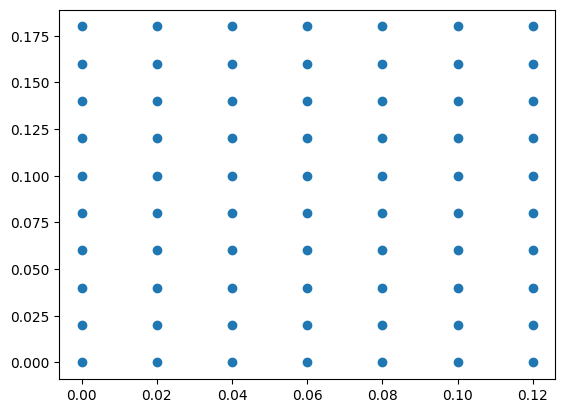

In [6]:
plt.scatter(objp[:, 0], objp[:, 1])

# Project points manually to camera frame

In [7]:
camera_intrinsics = np.array([[1.09148809e+03, 0.00000000e+00, 5.86208025e+02], # estimated earlier
                               [0.00000000e+00, 1.09838396e+03, 4.41593485e+02],
                               [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [8]:
camera_extrinsics = np.array([[ 0.1094668 , -0.86569452, -0.48845677,  0.08751609], # estimated earlier
                               [ 0.80313183, -0.21250686,  0.55661485, -0.05722432],
                               [-0.58565884, -0.45322602,  0.67200438,  0.32651949],
                               [ 0.        ,  0.        ,  0.        ,  1.        ]])
target_to_cam_T = camera_extrinsics

In [9]:
points_to_cam_T = target_to_cam_T @ points_to_target_T

In [10]:
points_to_cam_pose = T_to_pose(points_to_cam_T)

In [11]:
points_to_cam_positions = points_to_cam_pose[:, :3]

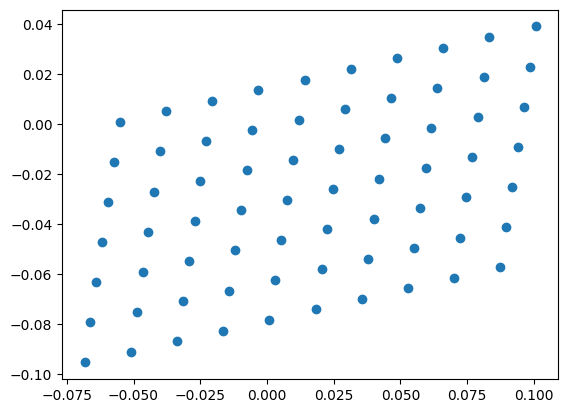

In [12]:
plt.scatter(points_to_cam_pose[:, 0], points_to_cam_pose[:, 1])

# Project points manually to the image plane

In [13]:
points_implane = (camera_intrinsics @ points_to_cam_positions.T).T

In [14]:
points_implane /= points_implane[:, 2][:, None]
points_implane = points_implane[:, :2]

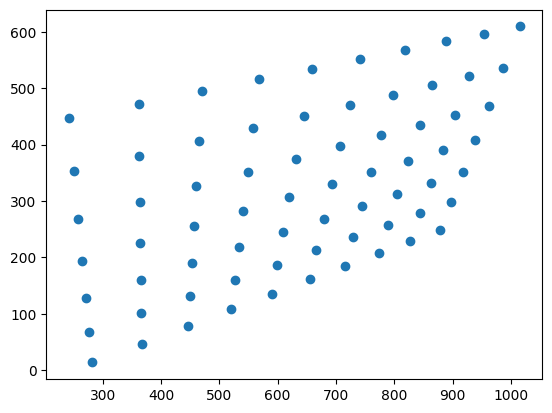

In [15]:
plt.scatter(points_implane[:, 0], points_implane[:, 1]);

# Compare to cv.projectpoints

In [16]:
import cv2

In [17]:
imgpoints2, _ = cv2.projectPoints(
    objp, target_to_cam_T[:3, :3], target_to_cam_T[:3, -1].reshape(1, 3), camera_intrinsics, np.zeros(5)
)
imgpoints2 = imgpoints2[:, 0, :]

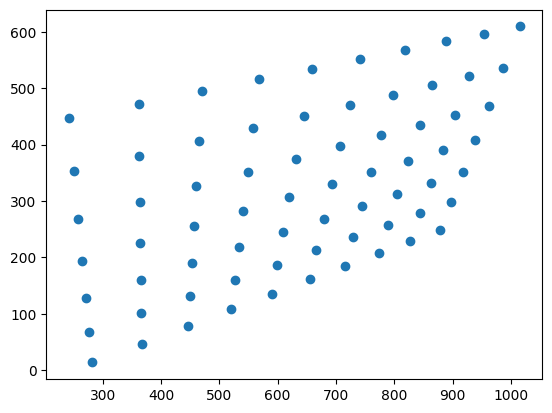

In [18]:
plt.scatter(imgpoints2[:, 0], imgpoints2[:, 1]);

# Calculate error

In [19]:
np.linalg.norm(imgpoints2 - points_implane[:, :2])

0.00015451213099277632